<a href="https://colab.research.google.com/github/berberberk/apms-fs-2024/blob/main/APMS_CoxBox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
import numpy as np
import pandas as pd
import scipy.stats as stats

# Set a random seed for reproducibility
np.random.seed(42)

# Generate synthetic dataset (100 samples)

# 1. Normally distributed data
normal_data = np.random.normal(loc=50, scale=10, size=100)

# 2. Data with outliers (mostly normal, with a few extreme values)
outlier_data = np.random.normal(loc=30, scale=5, size=95)
outlier_data = np.append(outlier_data, [80, 85, 90, 95, 100])  # Adding outliers

# 3. Skewed data (exponential distribution)
r_skewed_data = np.random.exponential(scale=10, size=100)
l_skewed_data = -np.random.exponential(scale=10, size=100) + 70

# 4. Multimodal data (combination of two normal distributions)
multimodal_data = np.concatenate([
    np.random.normal(loc=35, scale=5, size=50),  # First peak
    np.random.normal(loc=55, scale=5, size=50)  # Second peak
])

# 5. Data with all issues: outliers, skewness, multimodality
complex_data = np.concatenate([
    np.random.exponential(scale=8, size=70),  # Skewness
    np.random.normal(loc=50, scale=5, size=25),  # Multimodality (small peak)
    [100, 110, 120, 130, 140]  # Outliers
])

# Combine into a DataFrame
data = pd.DataFrame({
    "Normal": normal_data,
    "Outliers": outlier_data,
    "Right Skewed": r_skewed_data,
    "Multimodal": multimodal_data,
    "Complex": complex_data,
    "Left Skewed": l_skewed_data
})

# Add a dependent variable (e.g., "Response")
# Assume it is linearly dependent on the features with some noise
coefficients = [0.1, 0, 0, 0, 0]
noise = np.random.normal(0, 5, size=100)
data["Response"] = (
    coefficients[0] * data["Normal"] +
    coefficients[1] * data["Outliers"] +
    coefficients[2] * data["Right Skewed"] +
    coefficients[3] * data["Multimodal"] +
    coefficients[4] * data["Complex"] +
    noise
)

# Preview the dataset
data.head()


,Normal,Outliers,Right Skewed,Multimodal,Complex,Left Skewed,Response
0,54.967142,22.923146,8.441123,36.926587,1.848738,41.827445,1.194647
1,48.617357,27.896773,1.022282,36.613593,3.623849,61.432176,2.938958
2,56.476885,28.286427,9.545307,30.863845,5.600041,65.086993,10.679153
3,65.230299,25.988614,46.105697,37.596733,9.379659,59.691728,3.638571
4,47.658466,29.193571,1.509206,42.663695,0.320846,63.870440,8.944307


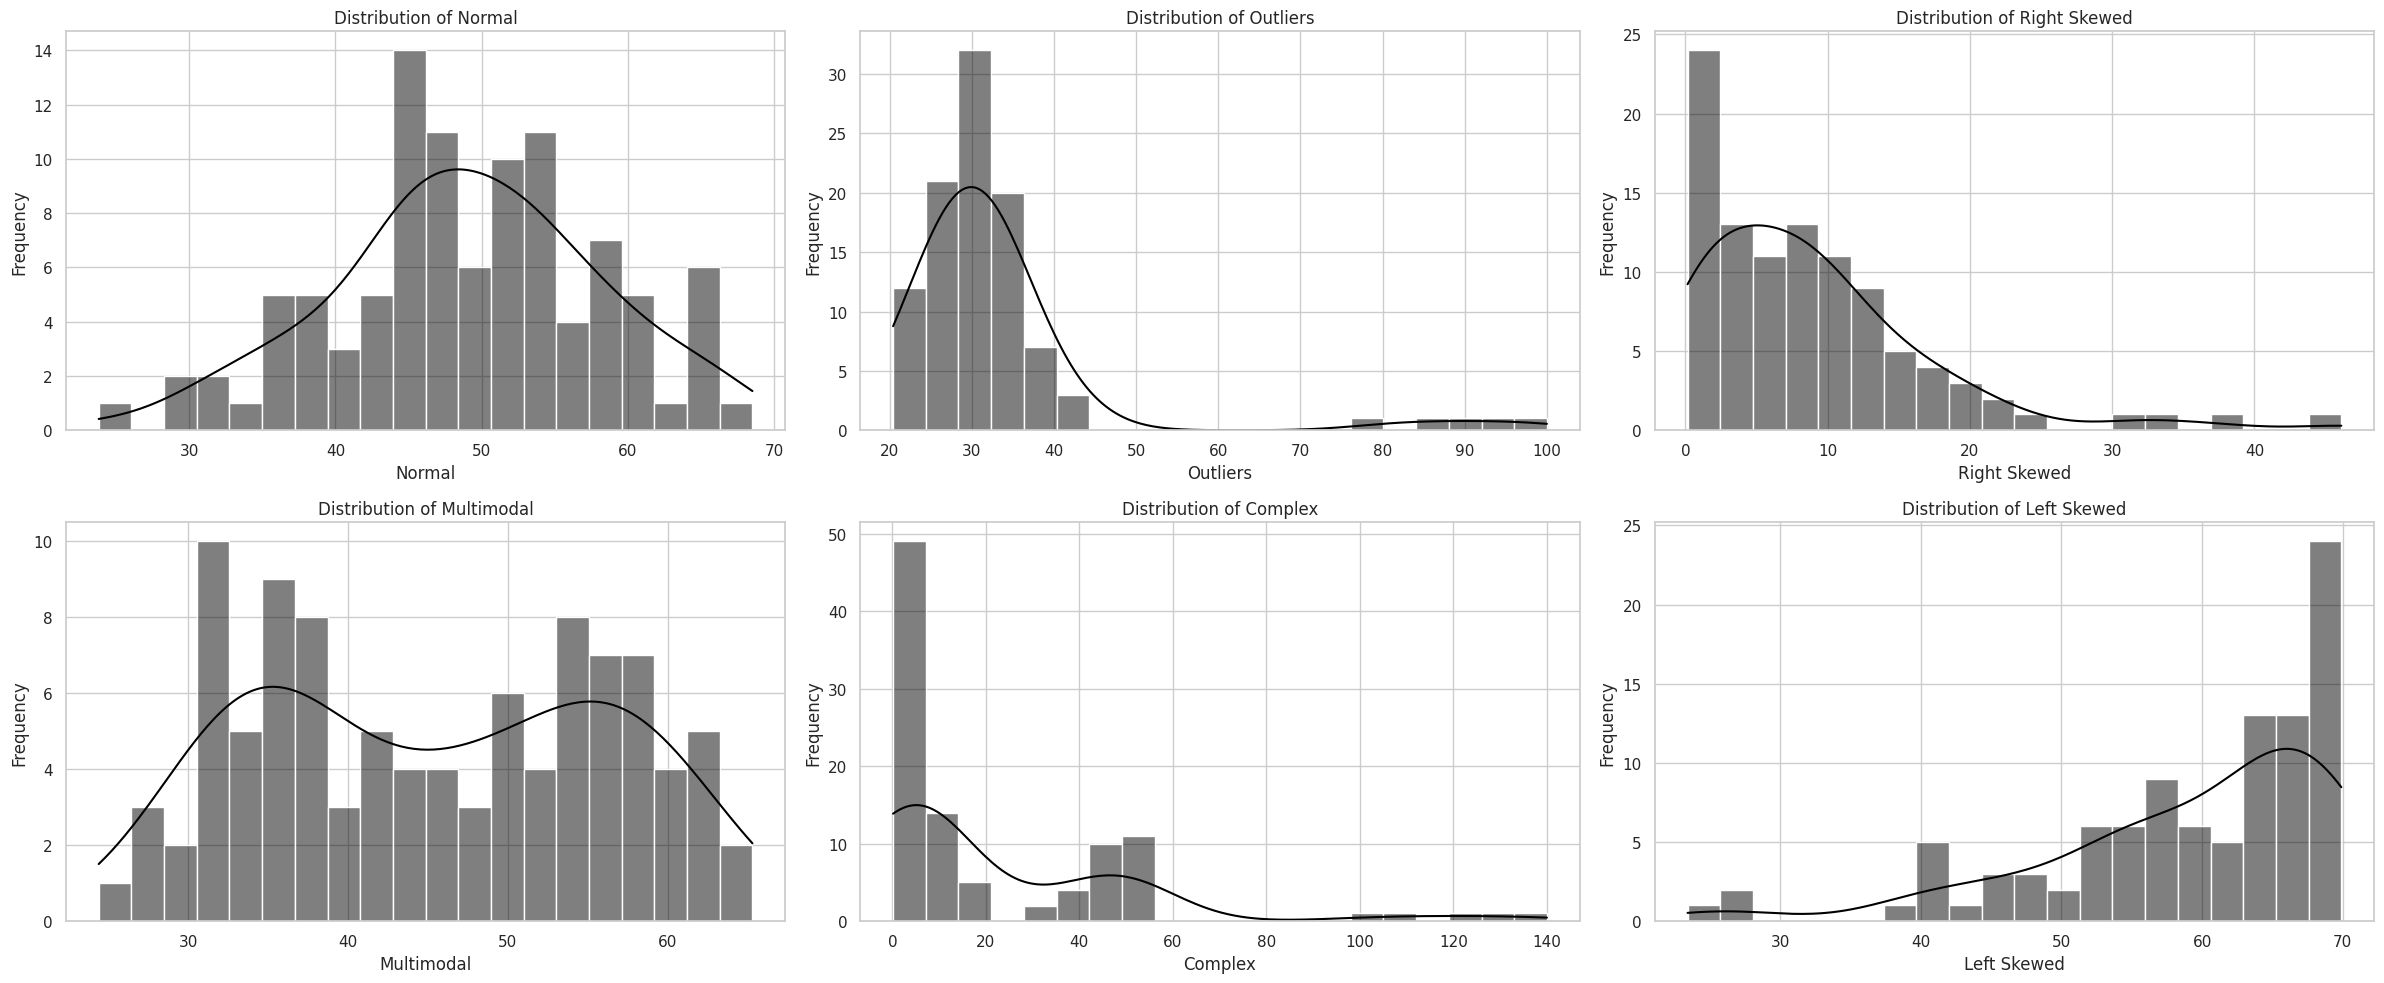

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting environment
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(24, 10))

# Plot each feature's distribution
features = ["Normal", "Outliers", "Right Skewed", "Multimodal", "Complex", "Left Skewed"]
for i, feature in enumerate(features):
    ax = axes.flat[i]
    sns.histplot(data[feature], kde=True, bins=20, ax=ax, alpha=0.5, color="black")
    ax.set_title(f"Distribution of {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Frequency")

# Adjust layout
plt.tight_layout()
plt.show()


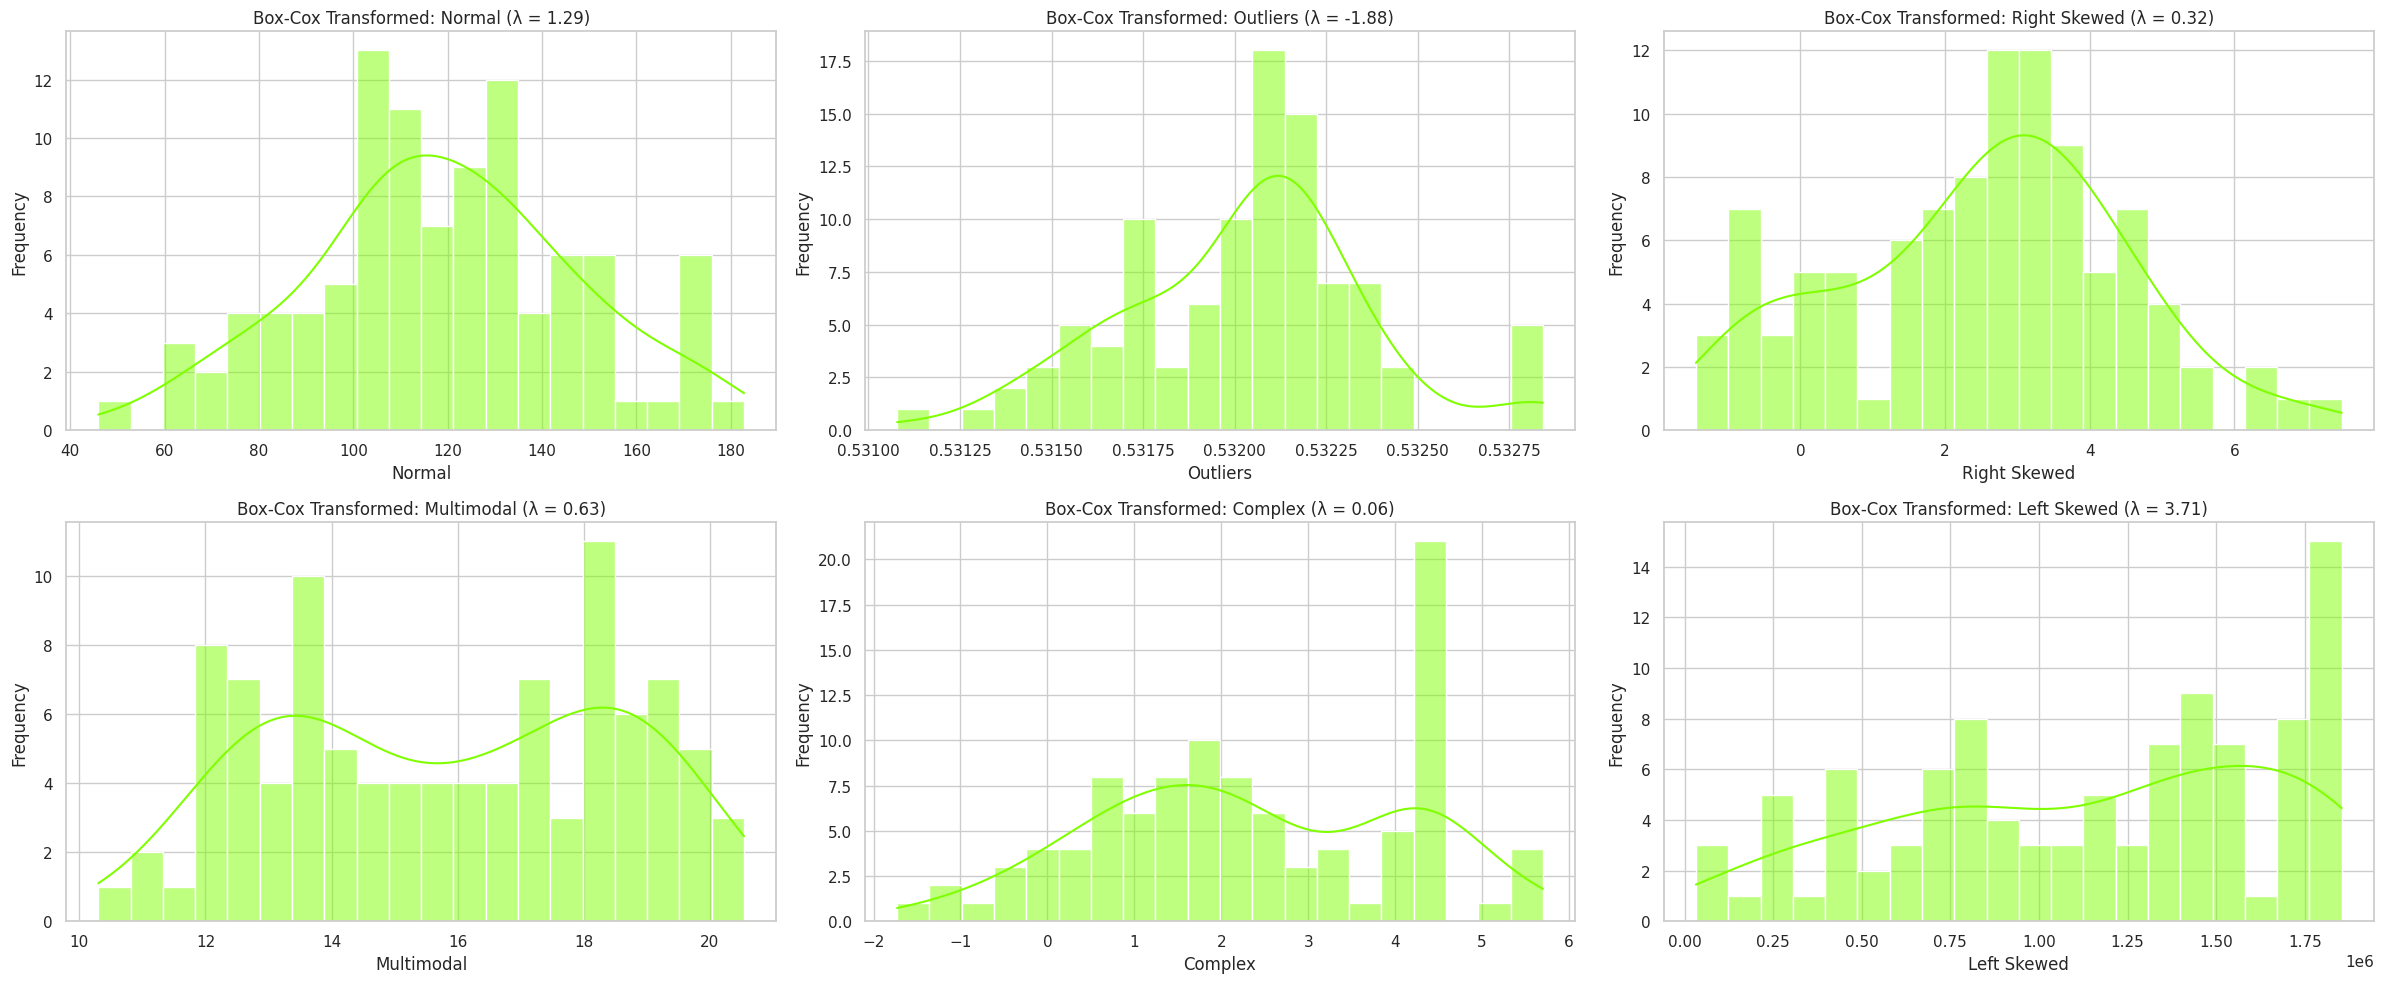

In [93]:
# Apply Box-Cox transformation to the applicable features
# Box-Cox requires all values to be positive, so we shift data if necessary
boxcox_transformed = {}
lmbda_values = {}

for feature in features:
    # Shift if there are non-positive values
    shifted_data = data[feature] - data[feature].min() + 1 if data[feature].min() <= 0 else data[feature]
    # Apply Box-Cox transformation
    transformed, lmbda = stats.boxcox(shifted_data)
    boxcox_transformed[feature] = transformed
    lmbda_values[feature] = lmbda

# Convert transformed data to a DataFrame for easier handling
boxcox_df = pd.DataFrame(boxcox_transformed)

# Visualize distributions after Box-Cox transformation
fig, axes = plt.subplots(2, 3, figsize=(24, 10))
for i, feature in enumerate(features):
    ax = axes.flat[i]
    sns.histplot(boxcox_df[feature], kde=True, bins=20, ax=ax, alpha=0.5, color="#7fff00")
    ax.set_title(f"Box-Cox Transformed: {feature} (λ = {lmbda_values[feature]:.2f})")
    ax.set_xlabel(feature)
    ax.set_ylabel("Frequency")

# Adjust layout
plt.tight_layout()
plt.show()


Metrics for Original Features:
Mean Squared Error (MSE): 23.8222
R-squared (R2): 0.0701

Metrics for Transformed Features:
Mean Squared Error (MSE): 23.4395
R-squared (R2): 0.0851

Box-Cox transformed features lead to a lower MSE.
Box-Cox transformed features improve the R-squared value.


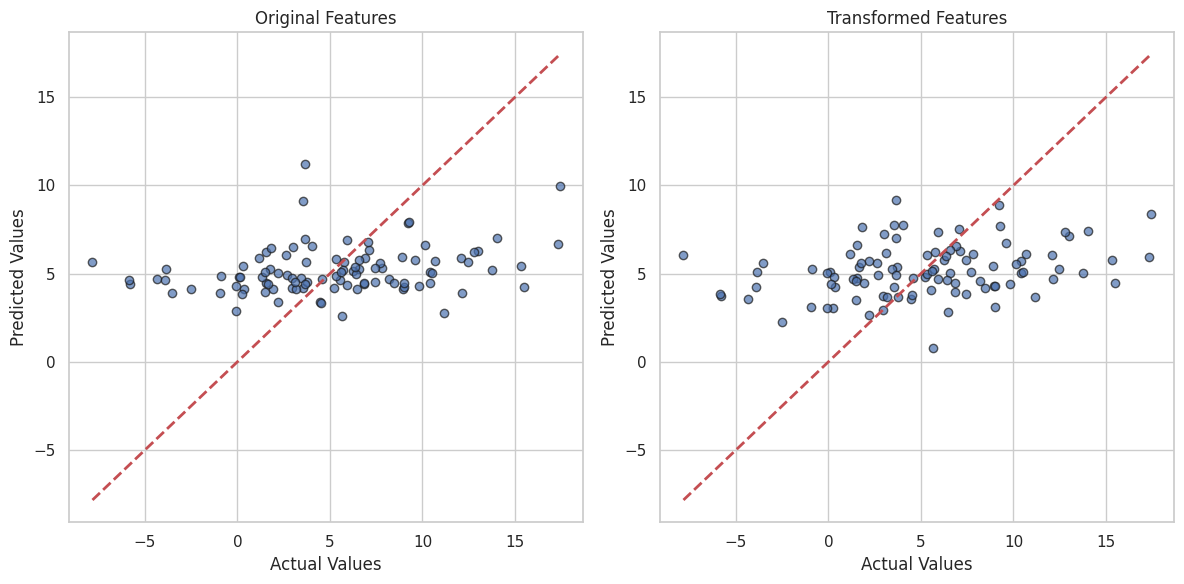

In [96]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Prepare the features and target for original and transformed data
X_original = data[features]
y = data["Response"]

X_transformed = boxcox_df[features]  # Use Box-Cox transformed features

# Train linear regression models
model_original = LinearRegression().fit(X_original, y)
model_transformed = LinearRegression().fit(X_transformed, y)

# Predictions
y_pred_original = model_original.predict(X_original)
y_pred_transformed = model_transformed.predict(X_transformed)

# Calculate metrics
mse_original = mean_squared_error(y, y_pred_original)
r2_original = r2_score(y, y_pred_original)

mse_transformed = mean_squared_error(y, y_pred_transformed)
r2_transformed = r2_score(y, y_pred_transformed)

mse_original, r2_original, mse_transformed, r2_transformed


# Print metrics for original features
print("Metrics for Original Features:")
print(f"Mean Squared Error (MSE): {mse_original:.4f}")
print(f"R-squared (R2): {r2_original:.4f}\n")

# Print metrics for transformed features
print("Metrics for Transformed Features:")
print(f"Mean Squared Error (MSE): {mse_transformed:.4f}")
print(f"R-squared (R2): {r2_transformed:.4f}\n")

# Compare results
if mse_transformed < mse_original:
    print("Box-Cox transformed features lead to a lower MSE.")
else:
    print("Original features lead to a lower MSE.")

if r2_transformed > r2_original:
    print("Box-Cox transformed features improve the R-squared value.")
else:
    print("Original features provide a better R-squared value.")

# Plot the actual vs predicted values for original and transformed features
plt.figure(figsize=(12, 6))

# Plot for original features
plt.subplot(1, 2, 1)
plt.scatter(y, y_pred_original, alpha=0.7, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Original Features")
plt.grid(True)

# Plot for transformed features
plt.subplot(1, 2, 2)
plt.scatter(y, y_pred_transformed, alpha=0.7, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Transformed Features")
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()


Метрики для оригинальных данных:
MSE: 22.4340, R2: 0.8632

Метрики для трансформированных данных:
MSE: 25.8307, R2: 0.8425

Box-Cox трансформация не улучшила MSE.
Box-Cox трансформация не улучшила R2.


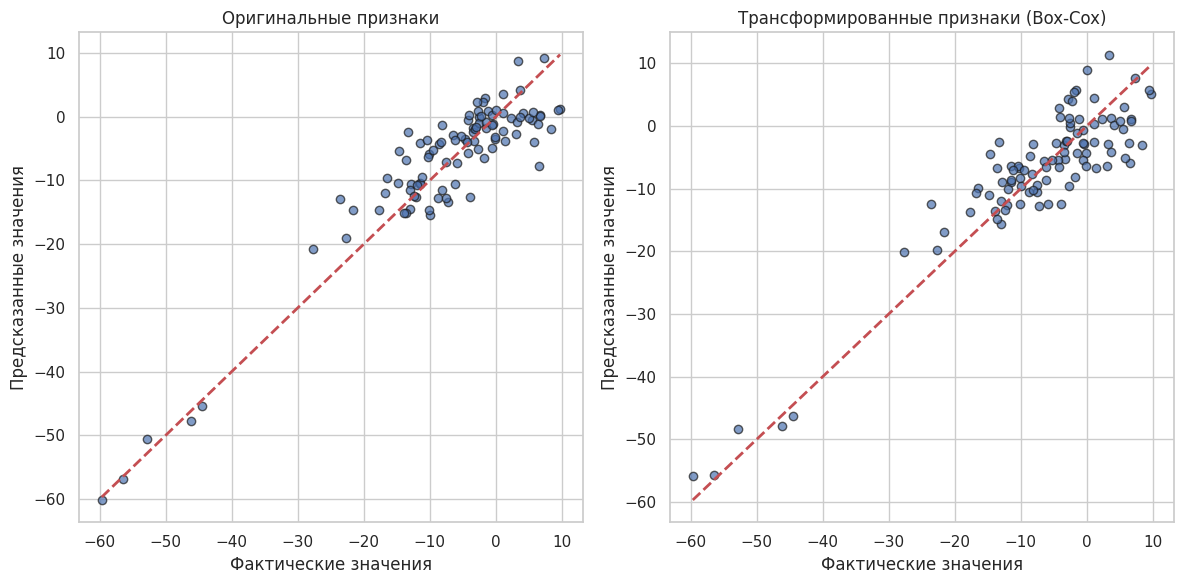

In [54]:
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PowerTransformer

# Box-Cox transformation requires strictly positive data
boxcox_df = data.copy()
for col in ["Skewed", "Complex"]:  # Применяем только к наиболее проблемным колонкам
    boxcox_df[col], _ = boxcox(data[col] + 1e-6)  # Добавляем небольшое значение, чтобы избежать 0

# Подготовка данных
features = ["Normal", "Outliers", "Skewed", "Multimodal", "Complex"]
X_original = data[features]
y = data["Response"]

X_transformed = boxcox_df[features]

# Обучение моделей
model_original = LinearRegression().fit(X_original, y)
model_transformed = LinearRegression().fit(X_transformed, y)

# Предсказания
y_pred_original = model_original.predict(X_original)
y_pred_transformed = model_transformed.predict(X_transformed)

# Метрики
mse_original = mean_squared_error(y, y_pred_original)
r2_original = r2_score(y, y_pred_original)

mse_transformed = mean_squared_error(y, y_pred_transformed)
r2_transformed = r2_score(y, y_pred_transformed)

# Вывод метрик
print("Метрики для оригинальных данных:")
print(f"MSE: {mse_original:.4f}, R2: {r2_original:.4f}")

print("\nМетрики для трансформированных данных:")
print(f"MSE: {mse_transformed:.4f}, R2: {r2_transformed:.4f}")

# Сравнение метрик
if mse_transformed < mse_original:
    print("\nBox-Cox трансформация улучшила MSE.")
else:
    print("\nBox-Cox трансформация не улучшила MSE.")

if r2_transformed > r2_original:
    print("Box-Cox трансформация улучшила R2.")
else:
    print("Box-Cox трансформация не улучшила R2.")

# Графическое представление
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# График для оригинальных признаков
plt.subplot(1, 2, 1)
plt.scatter(y, y_pred_original, alpha=0.7, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel("Фактические значения")
plt.ylabel("Предсказанные значения")
plt.title("Оригинальные признаки")
plt.grid(True)

# График для трансформированных признаков
plt.subplot(1, 2, 2)
plt.scatter(y, y_pred_transformed, alpha=0.7, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel("Фактические значения")
plt.ylabel("Предсказанные значения")
plt.title("Трансформированные признаки (Box-Cox)")
plt.grid(True)

plt.tight_layout()
plt.show()
